References:
- https://github.com/elisno/outlier_mnli/blob/main/outlier_mnli.ipynb
- https://towardsdatascience.com/understanding-outliers-in-text-data-with-transformers-cleanlab-and-topic-modeling-db3585415a19

In [7]:
import pickle
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from cleanlab.outlier import OutOfDistribution
from umap import UMAP
from hdbscan import HDBSCAN

embeddings_location = 'page-embeddings-selected.pkl'
outlier_scores_location = 'page-embeddings-selected-scores.pkl'

with open(embeddings_location, "rb") as reader:
    cache_data = pickle.load(reader)
    sections = cache_data['sections']
    corpus_embeddings = cache_data['embeddings']

/home/julrich/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-30 15:00:36.436074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ood = OutOfDistribution()
train_outlier_scores = ood.fit_score(features=corpus_embeddings)

Fitting OOD estimator based on provided features ...


In [3]:
with open(outlier_scores_location, "wb") as writer:
    pickle.dump({'scores': train_outlier_scores}, writer)

In [2]:
with open(outlier_scores_location, "rb") as reader:
    cache_data = pickle.load(reader)
    train_outlier_scores = cache_data['scores']

In [4]:
numpy_sections = np.array(sections)
numpy_embeddings = np.array(corpus_embeddings)

top_train_outlier_idxs = (train_outlier_scores).argsort()[:30]
outlier_sections = numpy_sections[top_train_outlier_idxs]

df = pd.DataFrame.from_records(pd.json_normalize(outlier_sections, sep='_'))
df['score'] = train_outlier_scores[top_train_outlier_idxs]
df.head(15)

,content,tokens,page_url,page_title,page_summary,score
0,"\nIn 2019, we worked with 23 different SuperFr...",304,https://danmall.com/posts/superfriendly-in-2020/,"“SuperFriendly in 2020,” an article by Dan Mall","Midway through 2019, we officially and publicl...",0.547226
1,Apprenticeships are common among many differen...,273,https://danmall.com/posts/apprenticeships-supe...,"Apprenticeships,” an article by Dan Mall",Our industry doesn’t do a great job of mixing ...,0.556840
2,"Practice\nDefinition\nIn my opinion, practice ...",280,https://danmall.com/posts/support-systems-for-...,"“Support Systems for Learning,” an essay by Da...",As we at SuperFriendly work with newer and/or ...,0.558885
3,Challenges along the way\nI spent the last yea...,262,https://bradfrost.com/blog/post/2014/,2014 | Brad Frost,It was my second year out on my own running my...,0.561680
4,Line\nLINE is a worldwide messaging platform w...,268,https://nuxtjs.org/case-studies,Nuxt - Case studies,GitHub Stars GitHub Stars recognises those fo...,0.565956
5,Comet\nby Discovery EducationComet is Discover...,257,https://backlight.dev/mastery/the-best-design-...,Best design system documentation sites | Desig...,Best design system documentation sites # Learn...,0.566824
6,Death to “full service.”\nPublished on 08 Feb ...,281,https://danmall.com/posts/oil-change-pizza/,"“Oil Change & Pizza,” an article by Dan Mall",It also made me think that maybe they’re not g...,0.571681
7,e\nexploratory research\nExploratory research ...,259,https://designstrategy.guide/dictionary/,Dictionary - Design strategy guide,Dictionary a agile Agile is a methodology that...,0.571737
8,Copy code to clipboardCopy\nThen the screen re...,272,https://build.washingtonpost.com/resources/acc...,WPDS - Semantic HTML and ARIA | Resources,Heading order and page landmarks Heading order...,0.577931
9,"\nCMYK: CMYK is an acronym for Cyan, Magenta, ...",293,https://design.gitlab.com/brand-design/color,Color | Pajamas Design System,Color Primary colors Charcoal and White provid...,0.578030


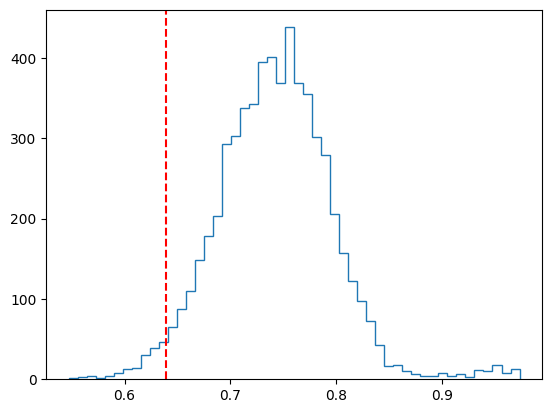

In [5]:
threshold = np.percentile(train_outlier_scores, 2.5)

plt_range = [train_outlier_scores.min(), train_outlier_scores.max()]

counts, bins = np.histogram(train_outlier_scores, range=plt_range, bins=50)
diagram = plt.stairs(counts, bins)
plt.axvline(threshold, color='r', linestyle='--')

In [6]:
sorted_ids = train_outlier_scores.argsort()
scores = train_outlier_scores[sorted_ids]
outlier_ids = sorted_ids[scores < threshold]
rest_ids = sorted_ids[scores >= threshold]
anomaly_ids = sorted_ids[scores > 0.999]
exclusive_ids = sorted_ids[np.logical_and(threshold <= scores, scores <= 0.999)]

outlier_sections = numpy_sections[outlier_ids]
outlier_embeddings = numpy_embeddings[outlier_ids]
outlier_scores = scores[outlier_ids]

rest_sections = numpy_sections[rest_ids]
rest_embeddings = numpy_embeddings[rest_ids]
rest_scores = scores[rest_ids]

anomaly_sections = numpy_sections[anomaly_ids]
anomaly_embeddings = numpy_embeddings[anomaly_ids]
anomaly_scores = scores[anomaly_ids]

exclusive_sections = numpy_sections[exclusive_ids]
exclusive_embeddings = numpy_embeddings[exclusive_ids]
exclusive_scores = scores[exclusive_ids]

df = pd.DataFrame.from_records(pd.json_normalize(outlier_sections, sep='_'))
df['score'] = train_outlier_scores[outlier_ids]
df.head(15)

,content,tokens,page_url,page_title,page_summary,score
0,"\nIn 2019, we worked with 23 different SuperFr...",304,https://danmall.com/posts/superfriendly-in-2020/,"“SuperFriendly in 2020,” an article by Dan Mall","Midway through 2019, we officially and publicl...",0.547226
1,Apprenticeships are common among many differen...,273,https://danmall.com/posts/apprenticeships-supe...,"Apprenticeships,” an article by Dan Mall",Our industry doesn’t do a great job of mixing ...,0.556840
2,"Practice\nDefinition\nIn my opinion, practice ...",280,https://danmall.com/posts/support-systems-for-...,"“Support Systems for Learning,” an essay by Da...",As we at SuperFriendly work with newer and/or ...,0.558885
3,Challenges along the way\nI spent the last yea...,262,https://bradfrost.com/blog/post/2014/,2014 | Brad Frost,It was my second year out on my own running my...,0.561680
4,Line\nLINE is a worldwide messaging platform w...,268,https://nuxtjs.org/case-studies,Nuxt - Case studies,GitHub Stars GitHub Stars recognises those fo...,0.565956
5,Comet\nby Discovery EducationComet is Discover...,257,https://backlight.dev/mastery/the-best-design-...,Best design system documentation sites | Desig...,Best design system documentation sites # Learn...,0.566824
6,Death to “full service.”\nPublished on 08 Feb ...,281,https://danmall.com/posts/oil-change-pizza/,"“Oil Change & Pizza,” an article by Dan Mall",It also made me think that maybe they’re not g...,0.571681
7,e\nexploratory research\nExploratory research ...,259,https://designstrategy.guide/dictionary/,Dictionary - Design strategy guide,Dictionary a agile Agile is a methodology that...,0.571737
8,Copy code to clipboardCopy\nThen the screen re...,272,https://build.washingtonpost.com/resources/acc...,WPDS - Semantic HTML and ARIA | Resources,Heading order and page landmarks Heading order...,0.577931
9,"\nCMYK: CMYK is an acronym for Cyan, Magenta, ...",293,https://design.gitlab.com/brand-design/color,Color | Pajamas Design System,Color Primary colors Charcoal and White provid...,0.578030


In [133]:
with open('outlier_embeddings.pkl', "wb") as writer:
    pickle.dump({'sections': outlier_sections, 'embeddings': outlier_embeddings}, writer)

with open('rest_embeddings.pkl', "wb") as writer:
    pickle.dump({'sections': rest_sections, 'embeddings': rest_embeddings}, writer)

with open('anomaly_embeddings.pkl', "wb") as writer:
    pickle.dump({'sections': anomaly_sections, 'embeddings': anomaly_embeddings}, writer)

with open('exclusive_embeddings.pkl', "wb") as writer:
    pickle.dump({'sections': exclusive_sections, 'embeddings': exclusive_embeddings}, writer)

In [7]:
outlier_umap_fit = UMAP(n_components=3, n_neighbors=8, random_state=42)
outlier_embeddings_umap = outlier_umap_fit.fit_transform(outlier_embeddings)

In [ ]:
df_outlier = pd.DataFrame.from_records(pd.json_normalize(outlier_sections, sep='_'))
df_outlier['score'] = train_outlier_scores[outlier_ids]
df_outlier['content'].apply(lambda x: x.replace('\n', ' ').strip())
df_outlier['x'] = outlier_embeddings_umap[:, 0]
df_outlier['y'] = outlier_embeddings_umap[:, 1]
df_outlier['z'] = outlier_embeddings_umap[:, 2]
df_outlier['domain'] = df_outlier['page_url'].apply(lambda x: urlparse(x).netloc)

fig_3d = px.scatter_3d(
    df_outlier, x='x', y='y', z='z',
    color=df_outlier.domain, labels={'color': 'domain'}, hover_data=['content'],
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

df_outlier.sample(10)

In [9]:
clusterer_outlier_umap_fit = UMAP(n_components=2, n_neighbors=8, random_state=42)
clusterer_outlier_embeddings_umap = clusterer_outlier_umap_fit.fit_transform(outlier_embeddings)

clusterer_outlier = HDBSCAN(min_cluster_size=6, min_samples=4)
clusterer_outlier.fit(clusterer_outlier_embeddings_umap)

HDBSCAN(min_cluster_size=6, min_samples=4)

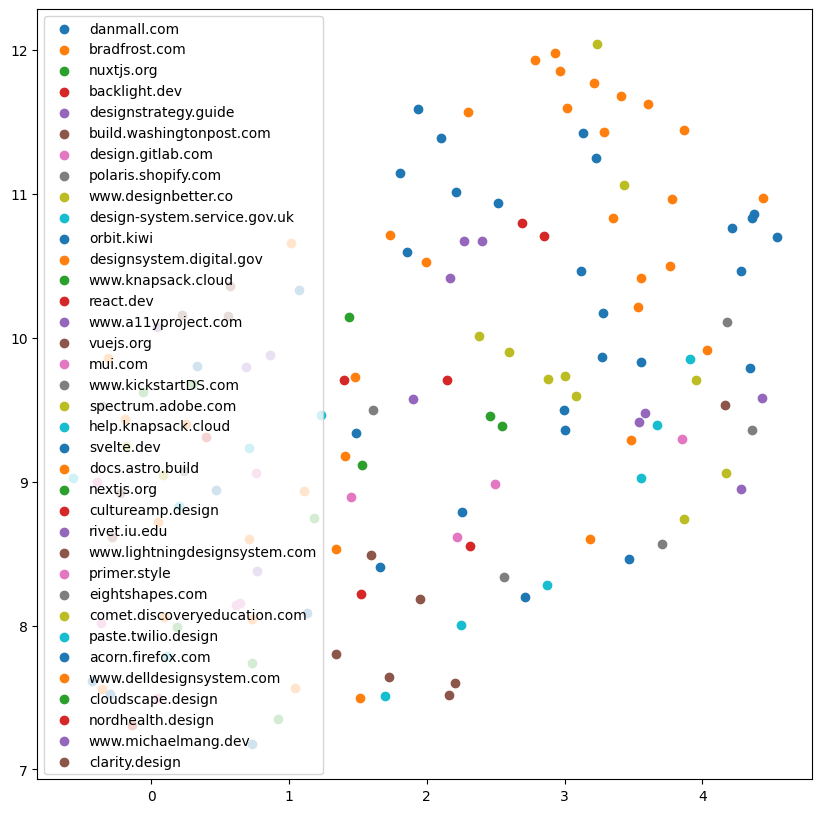

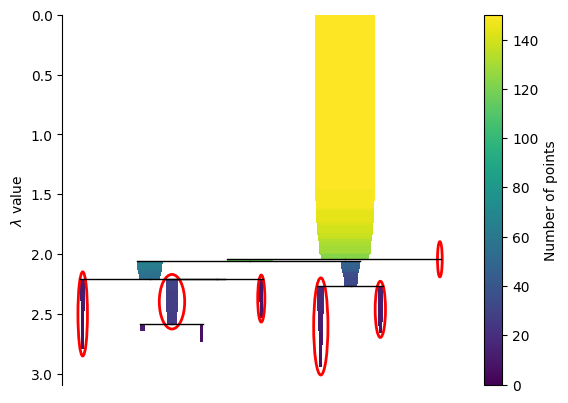

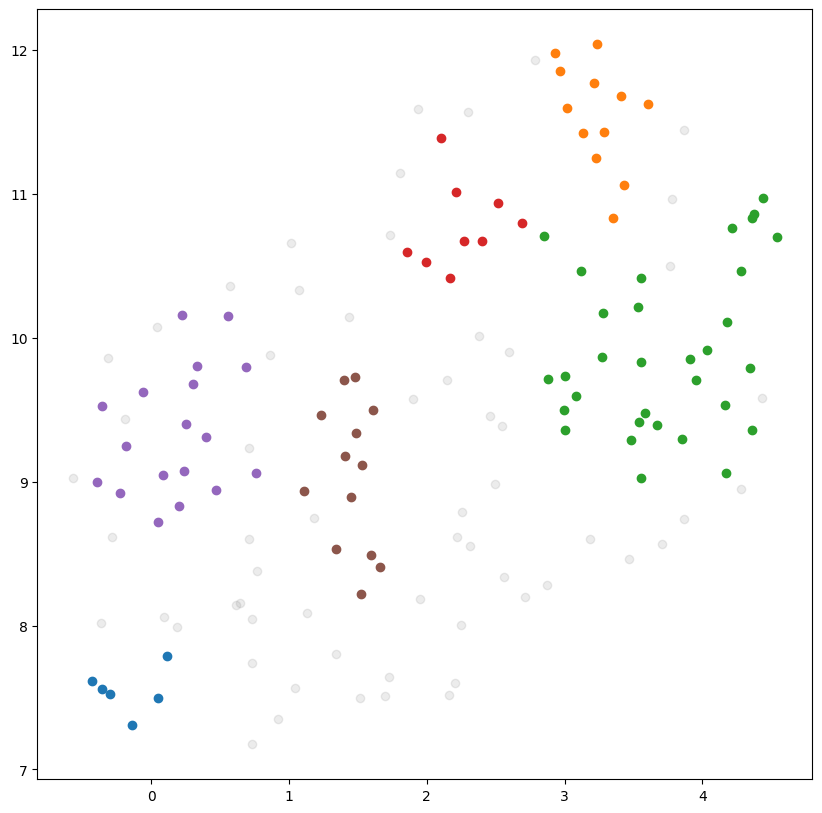

In [10]:
plt.figure(figsize=(10, 10))

outlier_x_plot, outlier_y_plot = clusterer_outlier_embeddings_umap[:, 0], clusterer_outlier_embeddings_umap[:, 1]
outlier_domain_labels = {k: v for v, k in enumerate(df_outlier['domain'].unique())}
outlier_assigned_labels = np.array([outlier_domain_labels.get(x, 0) for x in df_outlier['domain']])

for i, domain in enumerate(df_outlier['domain'].unique()):
    x, y = outlier_x_plot[outlier_assigned_labels == i], outlier_y_plot[outlier_assigned_labels == i]
    plt.scatter(x, y, label=domain)
plt.legend()
plt.show()

clusterer_outlier_labels = clusterer_outlier.labels_
clusterer_outlier.condensed_tree_.plot(select_clusters=True)

plt.figure(figsize=(10, 10))
for i in np.unique(clusterer_outlier_labels):
    if i != -1:
        x, y = outlier_x_plot[clusterer_outlier_labels == i], outlier_y_plot[clusterer_outlier_labels == i]
        plt.scatter(x, y, label=f"cluster {i}")

x, y = outlier_x_plot[clusterer_outlier_labels == -1], outlier_y_plot[clusterer_outlier_labels == -1]
plt.scatter(x, y, label="outliers", color="gray", alpha=0.15)
# plt.legend()
plt.show()

In [11]:
rest_umap_fit = UMAP(n_components=3, n_neighbors=8, random_state=42)
rest_embeddings_umap = rest_umap_fit.fit_transform(rest_embeddings)

In [ ]:
df_rest = pd.DataFrame.from_records(pd.json_normalize(rest_sections, sep='_'))
df_rest['score'] = train_outlier_scores[rest_ids]
df_rest['content'].apply(lambda x: x.replace('\n', ' ').strip())
df_rest['x'] = rest_embeddings_umap[:, 0]
df_rest['y'] = rest_embeddings_umap[:, 1]
df_rest['z'] = rest_embeddings_umap[:, 2]
df_rest['domain'] = df_rest['page_url'].apply(lambda x: urlparse(x).netloc)

fig_3d = px.scatter_3d(
    df_rest, x='x', y='y', z='z',
    color=df_rest.domain, labels={'color': 'domain'}, hover_data=['content'],
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

df_rest.sample(10)

In [13]:
clusterer_rest_umap_fit = UMAP(n_components=2, n_neighbors=8, random_state=42)
clusterer_rest_embeddings_umap = clusterer_rest_umap_fit.fit_transform(rest_embeddings)

clusterer_rest = HDBSCAN(min_cluster_size=6, min_samples=4)
clusterer_rest.fit(clusterer_rest_embeddings_umap)

HDBSCAN(min_cluster_size=6, min_samples=4)

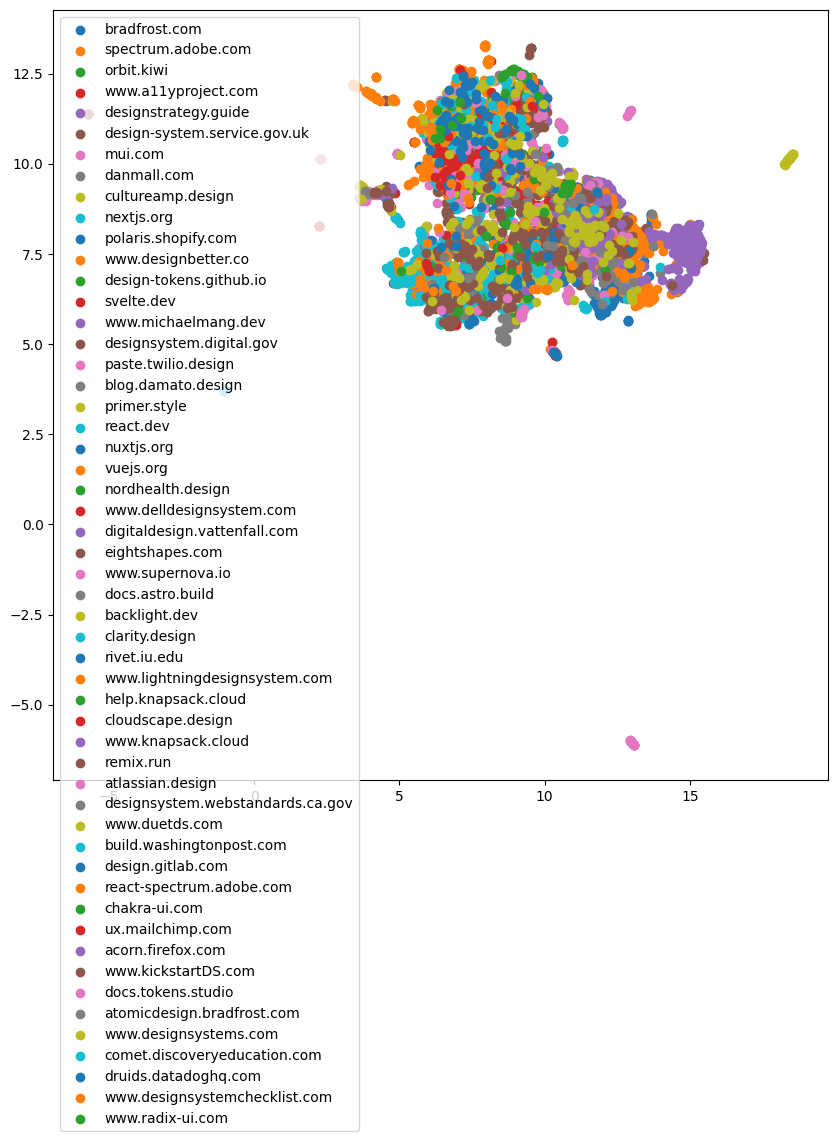

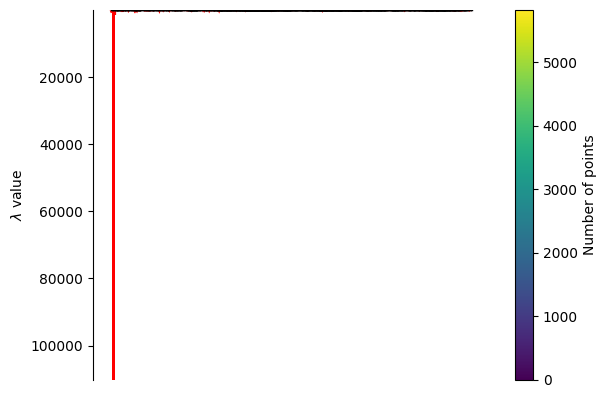

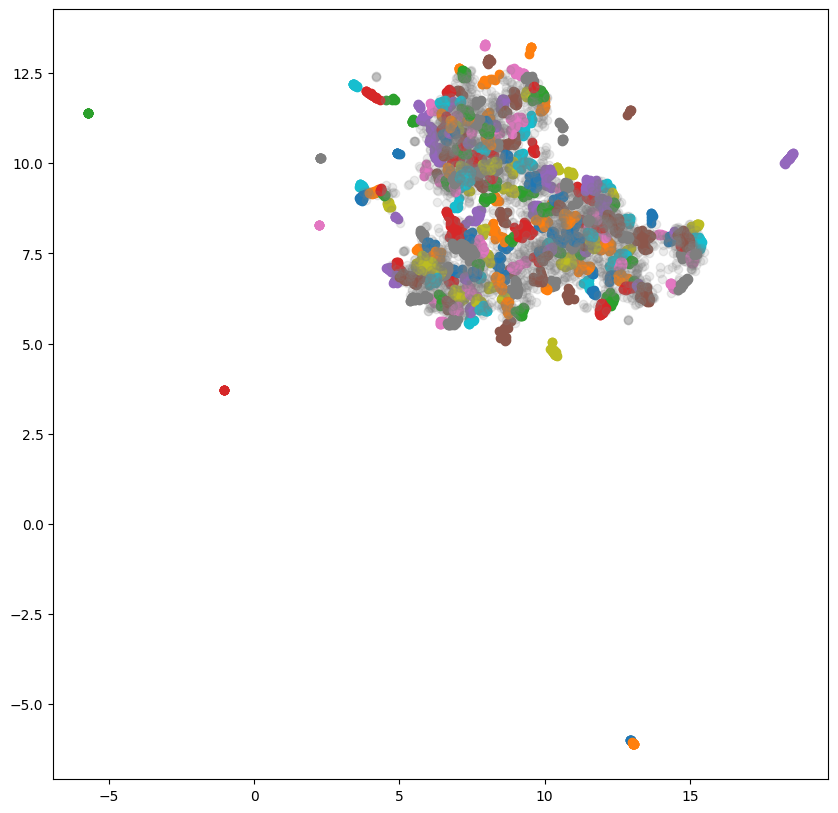

In [14]:
plt.figure(figsize=(10, 10))

rest_x_plot, rest_y_plot = clusterer_rest_embeddings_umap[:, 0], clusterer_rest_embeddings_umap[:, 1]
rest_domain_labels = {k: v for v, k in enumerate(df_rest['domain'].unique())}
rest_assigned_labels = np.array([rest_domain_labels.get(x, 0) for x in df_rest['domain']])

for i, domain in enumerate(df_rest['domain'].unique()):
    x, y = rest_x_plot[rest_assigned_labels == i], rest_y_plot[rest_assigned_labels == i]
    plt.scatter(x, y, label=domain)
plt.legend()
plt.show()

clusterer_rest_labels = clusterer_rest.labels_
clusterer_rest.condensed_tree_.plot(select_clusters=True)

plt.figure(figsize=(10, 10))
for i in np.unique(clusterer_rest_labels):
    if i != -1:
        x, y = rest_x_plot[clusterer_rest_labels == i], rest_y_plot[clusterer_rest_labels == i]
        plt.scatter(x, y, label=f"cluster {i}")

x, y = rest_x_plot[clusterer_rest_labels == -1], rest_y_plot[clusterer_rest_labels == -1]
plt.scatter(x, y, label="outliers", color="gray", alpha=0.15)
# plt.legend()
plt.show()

In [ ]:
anomaly_umap_fit = UMAP(n_components=3, n_neighbors=8, random_state=42)
anomaly_embeddings_umap = anomaly_umap_fit.fit_transform(anomaly_embeddings)

In [ ]:
df_anomaly = pd.DataFrame.from_records(pd.json_normalize(anomaly_sections, sep='_'))
df_anomaly['score'] = train_outlier_scores[anomaly_ids]
df_anomaly['content'].apply(lambda x: x.replace('\n', ' ').strip())
df_anomaly['x'] = anomaly_embeddings_umap[:, 0]
df_anomaly['y'] = anomaly_embeddings_umap[:, 1]
df_anomaly['z'] = anomaly_embeddings_umap[:, 2]
df_anomaly['domain'] = df_anomaly['page_url'].apply(lambda x: urlparse(x).netloc)

fig_3d = px.scatter_3d(
    df_anomaly, x='x', y='y', z='z',
    color=df_anomaly.domain, labels={'color': 'domain'}, hover_data=['content'],
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

df_anomaly.sample(10)

In [ ]:
clusterer_anomaly_umap_fit = UMAP(n_components=2, n_neighbors=8, random_state=42)
clusterer_anomaly_embeddings_umap = clusterer_anomaly_umap_fit.fit_transform(anomaly_embeddings)

clusterer_anomaly = HDBSCAN(min_cluster_size=6, min_samples=4)
clusterer_anomaly.fit(clusterer_anomaly_embeddings_umap)

In [ ]:
plt.figure(figsize=(10, 10))

anomaly_x_plot, anomaly_y_plot = clusterer_anomaly_embeddings_umap[:, 0], clusterer_anomaly_embeddings_umap[:, 1]
anomaly_domain_labels = {k: v for v, k in enumerate(df_anomaly['domain'].unique())}
anomaly_assigned_labels = np.array([anomaly_domain_labels.get(x, 0) for x in df_anomaly['domain']])

for i, domain in enumerate(df_anomaly['domain'].unique()):
    x, y = anomaly_x_plot[anomaly_assigned_labels == i], anomaly_y_plot[anomaly_assigned_labels == i]
    plt.scatter(x, y, label=domain)
plt.legend()
plt.show()

clusterer_anomaly_labels = clusterer_anomaly.labels_
clusterer_anomaly.condensed_tree_.plot(select_clusters=True)

plt.figure(figsize=(10, 10))
for i in np.unique(clusterer_anomaly_labels):
    if i != -1:
        x, y = anomaly_x_plot[clusterer_anomaly_labels == i], anomaly_y_plot[clusterer_anomaly_labels == i]
        plt.scatter(x, y, label=f"cluster {i}")

x, y = anomaly_x_plot[clusterer_anomaly_labels == -1], anomaly_y_plot[clusterer_anomaly_labels == -1]
plt.scatter(x, y, label="outliers", color="gray", alpha=0.15)
# plt.legend()
plt.show()

In [16]:
exclusive_umap_fit = UMAP(n_components=3, n_neighbors=8, random_state=42)
exclusive_embeddings_umap = exclusive_umap_fit.fit_transform(exclusive_embeddings)

In [ ]:
df_exclusive = pd.DataFrame.from_records(pd.json_normalize(exclusive_sections, sep='_'))
df_exclusive['score'] = train_outlier_scores[exclusive_ids]
df_exclusive['content'].apply(lambda x: x.replace('\n', ' ').strip())
df_exclusive['x'] = exclusive_embeddings_umap[:, 0]
df_exclusive['y'] = exclusive_embeddings_umap[:, 1]
df_exclusive['z'] = exclusive_embeddings_umap[:, 2]
df_exclusive['domain'] = df_exclusive['page_url'].apply(lambda x: urlparse(x).netloc)

fig_3d = px.scatter_3d(
    df_exclusive, x='x', y='y', z='z',
    color=df_exclusive.domain, labels={'color': 'domain'}, hover_data=['content'],
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

df_exclusive.sample(10)

In [18]:
clusterer_exclusive_umap_fit = UMAP(n_components=2, n_neighbors=8, random_state=42)
clusterer_exclusive_embeddings_umap = clusterer_exclusive_umap_fit.fit_transform(exclusive_embeddings)

clusterer_exclusive = HDBSCAN(min_cluster_size=6, min_samples=4)
clusterer_exclusive.fit(clusterer_exclusive_embeddings_umap)

HDBSCAN(min_cluster_size=6, min_samples=4)

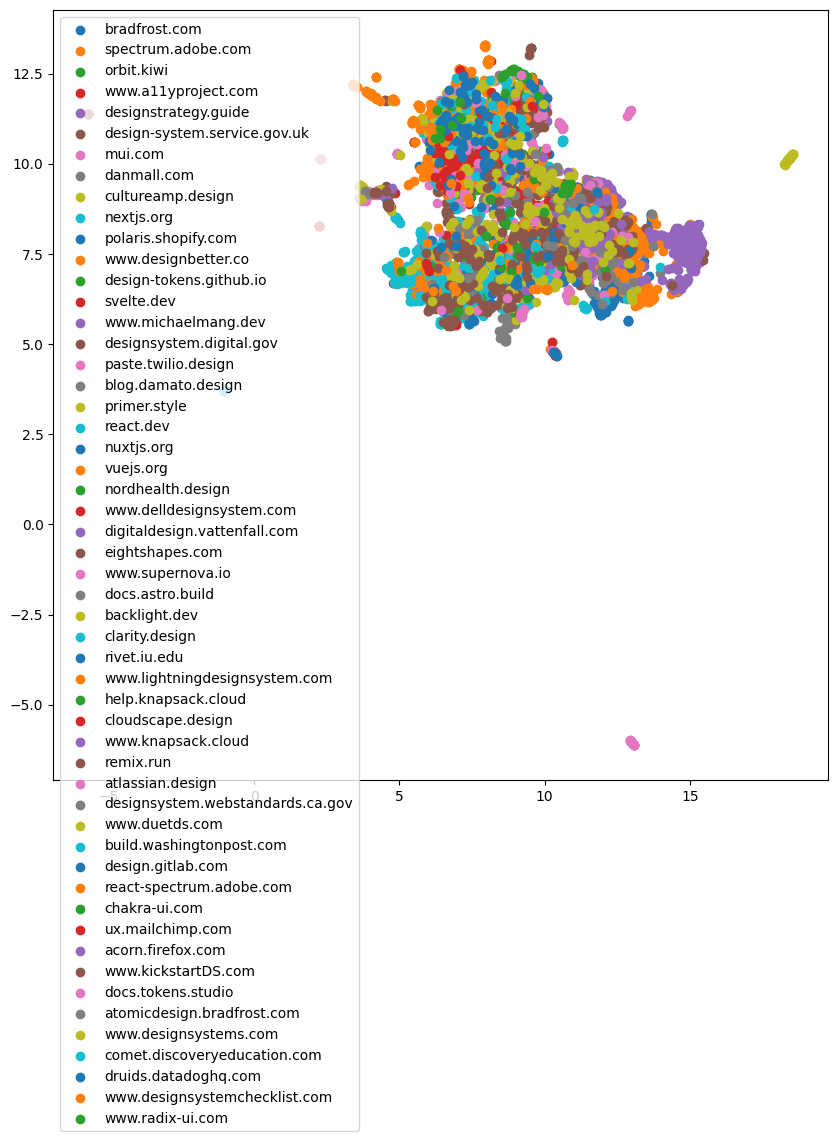

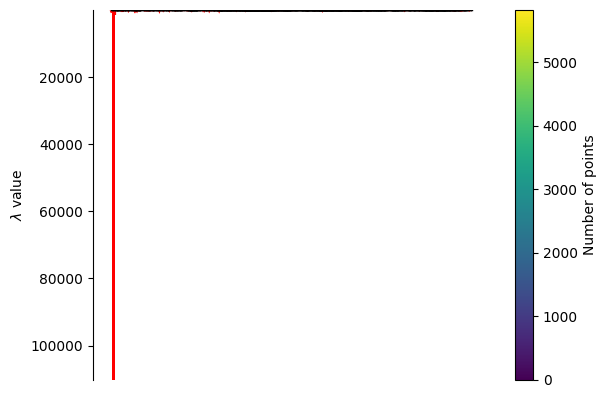

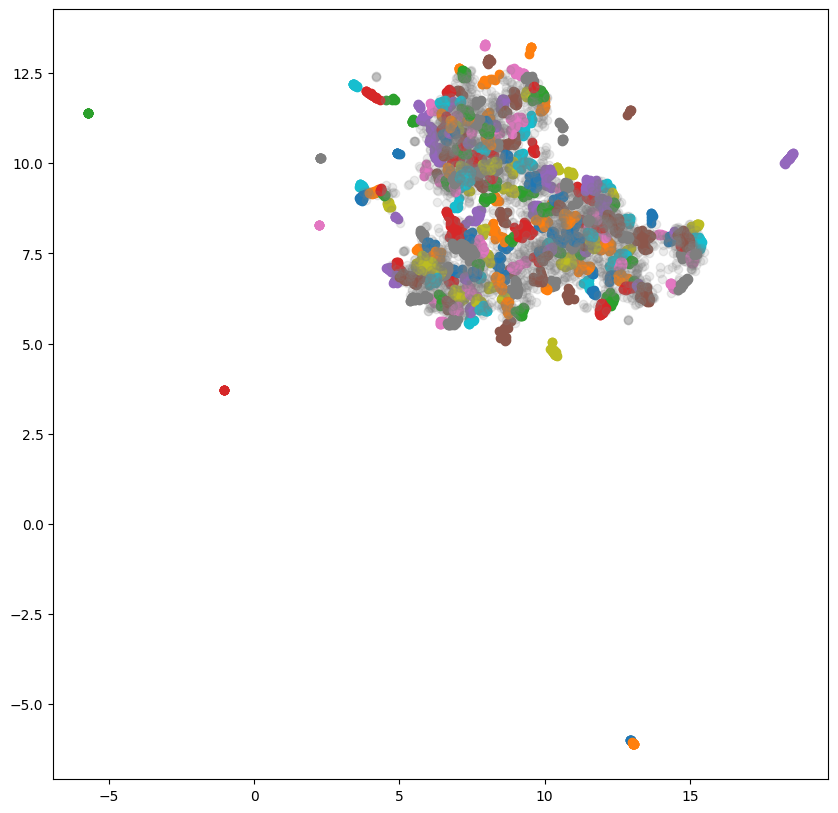

In [19]:
plt.figure(figsize=(10, 10))

exclusive_x_plot, exclusive_y_plot = clusterer_exclusive_embeddings_umap[:, 0], clusterer_exclusive_embeddings_umap[:, 1]
exclusive_domain_labels = {k: v for v, k in enumerate(df_exclusive['domain'].unique())}
exclusive_assigned_labels = np.array([exclusive_domain_labels.get(x, 0) for x in df_exclusive['domain']])

for i, domain in enumerate(df_exclusive['domain'].unique()):
    x, y = exclusive_x_plot[exclusive_assigned_labels == i], exclusive_y_plot[exclusive_assigned_labels == i]
    plt.scatter(x, y, label=domain)
plt.legend()
plt.show()

clusterer_exclusive_labels = clusterer_exclusive.labels_
clusterer_exclusive.condensed_tree_.plot(select_clusters=True)

plt.figure(figsize=(10, 10))
for i in np.unique(clusterer_exclusive_labels):
    if i != -1:
        x, y = exclusive_x_plot[clusterer_exclusive_labels == i], exclusive_y_plot[clusterer_exclusive_labels == i]
        plt.scatter(x, y, label=f"cluster {i}")

x, y = exclusive_x_plot[clusterer_exclusive_labels == -1], exclusive_y_plot[clusterer_exclusive_labels == -1]
plt.scatter(x, y, label="outliers", color="gray", alpha=0.15)
# plt.legend()
plt.show()